# Third notebook on dermoscopic images analysis

One of the most popular approaches to defining sharpness/bluriness of an images is to apply Laplacian operator which is an approximation of second derivative over discrete 2D matrix. As the result we have near 0 values around edges in the original image, therefore variance of the result can give us an estimate of how well the edges are defined in the image.

This approach works quite well in the regular images analysis and is widely used in computer vision application. However to compute the lapalcian we have to convert an RGB image into gray-scale space, loosing color information. Moreover human skin is quite smooth and lack many pronounced details, leading to significantly fewer well defined edges in any dermoscopic image.

That's why I showed in the first notebook that we can't use this simple approach of analyzing variance of laplacian operator over gray version of the dermoscopic images of the leisons. In the absolute majority of the images the variance is too low to set a definitive threshold on which to base the decision.

Therefore lets analyze these images in different color spaces and estimate **'sharpness index'** per each channel (still using variance of the laplacian operator). 
**The higher the number of the index the better** since it is a reflection of how many edges are there in the image.
We'll analyze the images by separate channels, plot the histograms, and display basic descriptive analytics.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from IPython.display import display_html
from PIL import Image
import gc
import cv2
from skimage.exposure import is_low_contrast, rescale_intensity
import random

# Directory
directory = '../input/siim-isic-melanoma-classification'
IMAGE_PATH = "../input/siim-isic-melanoma-classification/"
img_dir = IMAGE_PATH+'/jpeg/train'

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train.csv')
print(f'There are {train_df.shape[0]} records in the train set')

random.seed(1970)

There are 33126 records in the train set


Split data into benign and malignant leisons subsets. Pick 9 random samples from each for furthere analysis.

In [2]:
benign = train_df[train_df['benign_malignant']=='benign']
malignant = train_df[train_df['benign_malignant']=='malignant']
print(f'There are {benign.shape[0]} records in the benign set, and {malignant.shape[0]} in the malignant dataset')

random9_mal = [np.random.choice(malignant['image_name'].values+'.jpg') for i in range(9)]
random9_ben = [np.random.choice(benign['image_name'].values+'.jpg') for i in range(9)]

There are 32542 records in the benign set, and 584 in the malignant dataset


In [3]:
def variance_of_laplacian(image):
# compute the Laplacian of the image and then return the focus
# measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

def laplacian(image):
# compute the Laplacian of the image and then return the focus
# measure, which is simply the variance of the Laplacian
    res = cv2.Laplacian(image, cv2.CV_64F)
    lap_var = res.var()
    return res, lap_var

# show 9 images with Blur Index in 3*3 grid
def show9(images, l_type):
    print(f'{l_type} images with variance of laplacian of gray version of the images as Sharpness Index')

    # Adjust the size of your images
    plt.figure(figsize=(10,8))

    # Iterate and plot random images
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = plt.imread(os.path.join(img_dir, images[i]))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        fm = variance_of_laplacian(gray)
        plt.title(f'Sharpness Index : {fm:.2f}')
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()
    
def show9_RGB(images, l_type):
    print(f'Display {l_type} Images')
    N_subplots = 6
    color = ('b','g','r')

    # Iterate and plot random images
    for i in range(9):
        fig = plt.figure()
        fig.set_figwidth(20)
        fig.set_figheight(3)
        img = plt.imread(os.path.join(img_dir, images[i]))
        ax = fig.add_subplot(1, N_subplots, 1)
        imgplot = plt.imshow(img)
        ax.set_title(f'Size: {img.shape}')
        plt.axis('off')

        for i,col in enumerate(color):
            ax = fig.add_subplot(1, N_subplots, i+2)
            imgplot = plt.imshow(img[:,:,i], cmap='gray')
            ax.set_title(col)
            plt.axis('off')

        color = ('b','g','r')
        ax = fig.add_subplot(1, N_subplots, 5)
        for i,col in enumerate(color):
            histr = cv2.calcHist([img],[i],None,[256],[0,255]) #excluding pure white 255 pixels of the borders in the images
            plt.plot(histr,color = col)
            plt.xlim([0,256])

        ax = fig.add_subplot(1, N_subplots, 6)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mat, fm = laplacian(gray)
        ax.set_title(f'Bluriness index : {fm:.2f}')
        plt.hist(mat.ravel(), bins=100) 
        plt.show()    
        
# pass an image in BGR format as an input
def BGR2MI(img):
    MI = 100 * np.log10(1/(img[:,:,2].astype('float')+1))
    MI = MI + abs(MI.min())
    MI_rescaled = 255 * (MI / abs(MI.max()))
    return MI.astype('uint16'), MI_rescaled.astype('uint16')
#     return MI.astype('int'), MI_rescaled.astype('int')

# pass an image in BGR format as an input
def BGR2EI(img):
    EI = 100 * (np.log10(1/(img[:,:,1].astype('float')+1)) - 1.44 * np.log10(1/(img[:,:,2].astype('float')+1)))
    EI = EI + abs(EI.min())
    EI_rescaled = 255 * (EI / abs(EI.max()))
    return EI.astype('uint16'), EI_rescaled.astype('uint16')                
#   return EI.astype('int'), EI_rescaled.astype('int')                

## Melanin Index and Erythema Index

In this notebook I want to introduce Melanin Index and Erythema Index. I believe we can use it as for image quality analysis and so for our future lesion classifier.

In [4]:
def show_image_analytics(images, l_type):
    print(f'{l_type} Images')
    N_rows = 4
    N_cols = 4
    HSV_color = ('H','S','V')
    BGR_color = ('b','g','r')
    YCrCb_color = ('Y','Cr','Cb')
    plot_color = ('r','g','b')
    pcts = [5, 25, 50, 75, 95]
    blur_idxs = {'r': 0, 'g': 0, 'b': 0, 'H': 0, 'S': 0, 'V': 0, 'Y': 0, 'Cr': 0, 'Cb': 0, 'Gray': 0, 'MI': 0, 'EI': 0}


    # Iterate and plot random images
    for n_img in range(len(images)):
        fig = plt.figure()
        fig.set_figwidth(20)
        fig.set_figheight(14)
        img_BGR = cv2.imread(os.path.join(img_dir, images[n_img]))
        ax = fig.add_subplot(N_rows, N_cols, 1)
        imgplot = plt.imshow(cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB))
        ax.set_title(f'Size: {img_BGR.shape}')
        plt.axis('off')

        MI, MI_rescaled = BGR2MI(img_BGR)
        ax = fig.add_subplot(N_rows, N_cols, 2)
        imgplot = plt.imshow(MI, cmap='gray')
#         imgplot = plt.imshow(MI_rescaled, cmap='gray')
        ax.set_title(f'Melanin Index')
        plt.axis('off')
        
        EI, EI_rescaled = BGR2EI(img_BGR)      
        ax = fig.add_subplot(N_rows, N_cols, 3)
        imgplot = plt.imshow(EI, cmap='gray')
#         imgplot = plt.imshow(EI_rescaled, cmap='gray')
        ax.set_title(f'Erythema Index')
        plt.axis('off')
        
        blur_idxs['MI'] = variance_of_laplacian(MI)
        blur_idxs['EI'] = variance_of_laplacian(EI)
        
        gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
        
#         ax = fig.add_subplot(N_rows, N_cols, 2)
#         imgplot = plt.imshow(gray, cmap='gray')
#         ax.set_title(f'Size: {gray.shape}')
#         plt.axis('off')

        ax = fig.add_subplot(N_rows, N_cols, 4)
        mat, blur_idxs['Gray'] = laplacian(gray)
        ax.set_title('Laplacian of gray image')
        plt.hist(mat.ravel(), bins=100) 

        for i,col in enumerate(BGR_color):
            ax = fig.add_subplot(N_rows, N_cols, N_cols + i + 1)
            imgplot = plt.imshow(img_BGR[:,:,i], cmap='gray')
            ax.set_title(col)
            plt.axis('off')
            blur_idxs[col] = variance_of_laplacian(img_BGR[:,:,i])

        ax = fig.add_subplot(N_rows, N_cols, N_cols * 1 + 4)
        ax.set_title(f'Histograms of {BGR_color}')
        for i,col in enumerate(BGR_color):
            histr = cv2.calcHist([img_BGR],[i],None,[256],[0,255]) #excluding pure white 255 pixels of the borders in the images
            plt.plot(histr,color = col, label = BGR_color[i])
            plt.xlim([0,256])
        ax.legend()

        img = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2HSV)
        HSV_pcts = np.percentile(img, pcts)
        for i,col in enumerate(HSV_color):
            ax = fig.add_subplot(N_rows, N_cols, N_cols * 2 + i + 1)
            imgplot = plt.imshow(img[:,:,i], cmap='gray')
            ax.set_title(col)
            plt.axis('off')
            blur_idxs[col] = variance_of_laplacian(img[:,:,i])

        ax = fig.add_subplot(N_rows, N_cols, N_cols * 2 + 4)
        ax.set_title(f'Histograms of {HSV_color}')
        for i,col in enumerate(['pink','gold','indigo']):
            histr = cv2.calcHist([img],[i],None,[256],[0,255]) #excluding pure white 255 pixels of the borders in the images
            plt.plot(histr,color = col, label = HSV_color[i])
            plt.xlim([0,256])
        ax.legend()

        img = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCR_CB)
        YCrCb_pcts = np.percentile(img, pcts)
        for i,col in enumerate(YCrCb_color):
            ax = fig.add_subplot(N_rows, N_cols, N_cols * 3 + i + 1)
            imgplot = plt.imshow(img[:,:,i], cmap='gray')
            ax.set_title(col)
            plt.axis('off')
            blur_idxs[col] = variance_of_laplacian(img[:,:,i])

        ax = fig.add_subplot(N_rows, N_cols, N_cols * 3 + 4)
        ax.set_title(f'Histograms of {YCrCb_color}')
        for i,col in enumerate(['coral', 'olive', 'maroon']):
            histr = cv2.calcHist([img],[i],None,[256],[0,255]) #excluding pure white 255 pixels of the borders in the images
            plt.plot(histr,color = col, label = YCrCb_color[i])
            plt.xlim([0,256])
        ax.legend()

        plt.show()

        BGR_pcts = np.percentile(img_BGR, pcts)
        print(f'Percentiles of intensities in RGB space: {dict(zip(pcts,BGR_pcts))}')
        print(f'Percentiles of intensities in HSV space: {dict(zip(pcts,HSV_pcts))}')
        print(f'Percentiles of intensities in YCrCb space: {dict(zip(pcts,YCrCb_pcts))}')
        print('Sharpness Index: ')
        bis = ''
        for k in blur_idxs:
            bis = bis + k + f': {blur_idxs[k]:.2f}  '
        print(bis)
        pcts_conrast = [1, 5, 25, 50, 75, 95, 99]
        gray_pcts = np.percentile(gray, pcts_conrast)
        contrast_clipped = (gray_pcts[-1] - gray_pcts[0])/255
        contrast = (gray.max() - gray.min())/255
        print(f'Full contrast: {contrast:.2f}; clipped (1%-99%) contrast: {contrast_clipped:.2f}') #remove outliers
        
        print('-'*80)

Benign Images


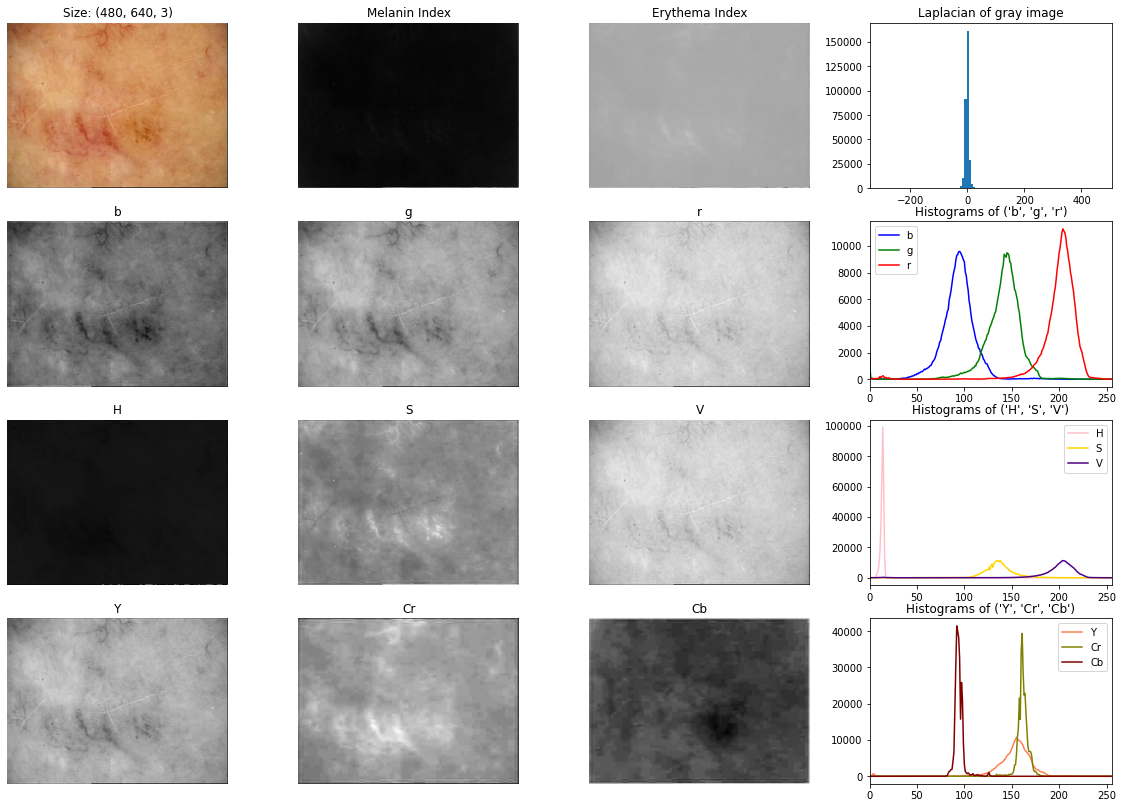

Percentiles of intensities in RGB space: {5: 77.0, 25: 101.0, 50: 143.0, 75: 195.0, 95: 215.0}
Percentiles of intensities in HSV space: {5: 12.0, 25: 14.0, 50: 136.0, 75: 195.0, 95: 215.0}
Percentiles of intensities in YCrCb space: {5: 91.0, 25: 96.0, 50: 154.0, 75: 162.0, 95: 171.0}
Sharpness Index: 
r: 807.26  g: 754.50  b: 638.49  H: 78.06  S: 1004.43  V: 807.30  Y: 754.85  Cr: 1.94  Cb: 3.25  Gray: 754.85  MI: 270.47  EI: 161.77  
Full contrast: 0.92; clipped (1%-99%) contrast: 0.38
--------------------------------------------------------------------------------


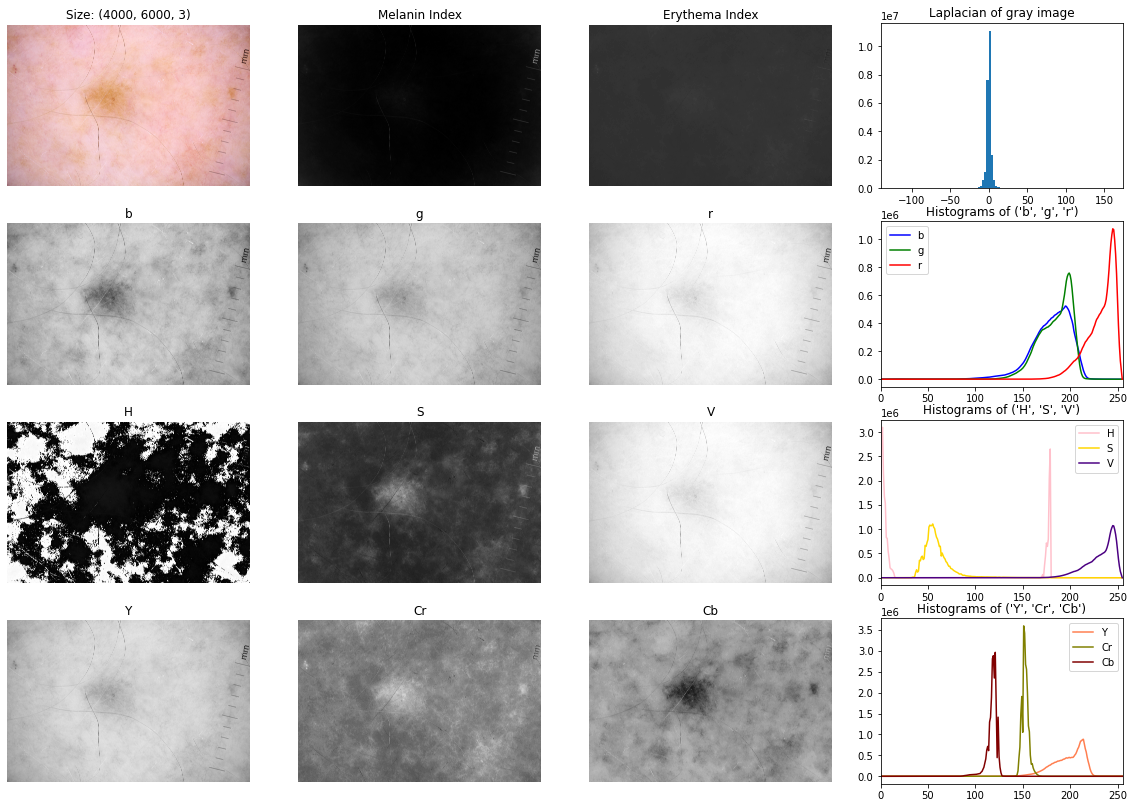

Percentiles of intensities in RGB space: {5: 154.0, 25: 178.0, 50: 196.0, 75: 224.0, 95: 247.0}
Percentiles of intensities in HSV space: {5: 1.0, 25: 43.0, 50: 68.0, 75: 224.0, 95: 247.0}
Percentiles of intensities in YCrCb space: {5: 114.0, 25: 121.0, 50: 152.0, 75: 187.0, 95: 214.0}
Sharpness Index: 
r: 15.88  g: 15.44  b: 16.98  H: 3460.90  S: 10.92  V: 15.88  Y: 14.50  Cr: 0.76  Cb: 0.71  Gray: 14.50  MI: 1.75  EI: 2.66  
Full contrast: 0.98; clipped (1%-99%) contrast: 0.27
--------------------------------------------------------------------------------


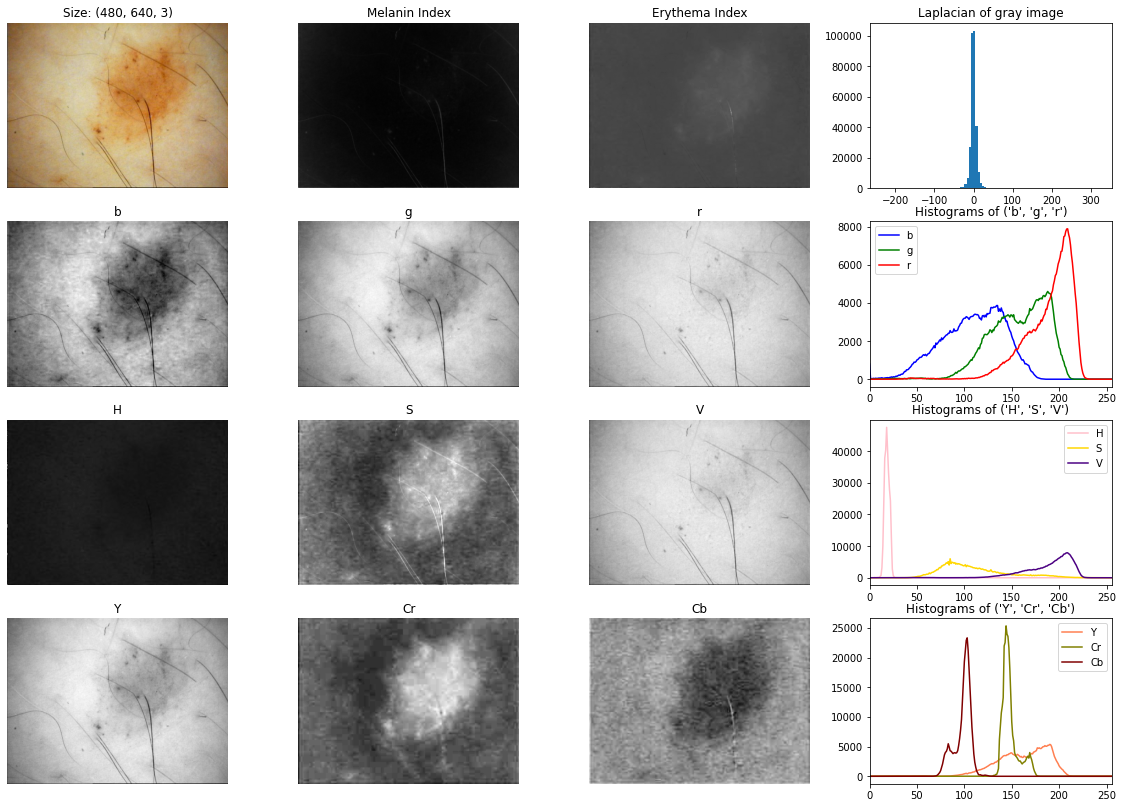

Percentiles of intensities in RGB space: {5: 71.0, 25: 122.0, 50: 156.0, 75: 190.0, 95: 212.0}
Percentiles of intensities in HSV space: {5: 16.0, 25: 20.0, 50: 101.0, 75: 182.0, 95: 212.0}
Percentiles of intensities in YCrCb space: {5: 86.0, 25: 104.0, 50: 143.0, 75: 156.0, 95: 190.0}
Sharpness Index: 
r: 234.95  g: 232.33  b: 217.25  H: 29.31  S: 266.05  V: 234.86  Y: 227.92  Cr: 1.40  Cb: 3.53  Gray: 227.91  MI: 39.36  EI: 10.33  
Full contrast: 0.85; clipped (1%-99%) contrast: 0.44
--------------------------------------------------------------------------------


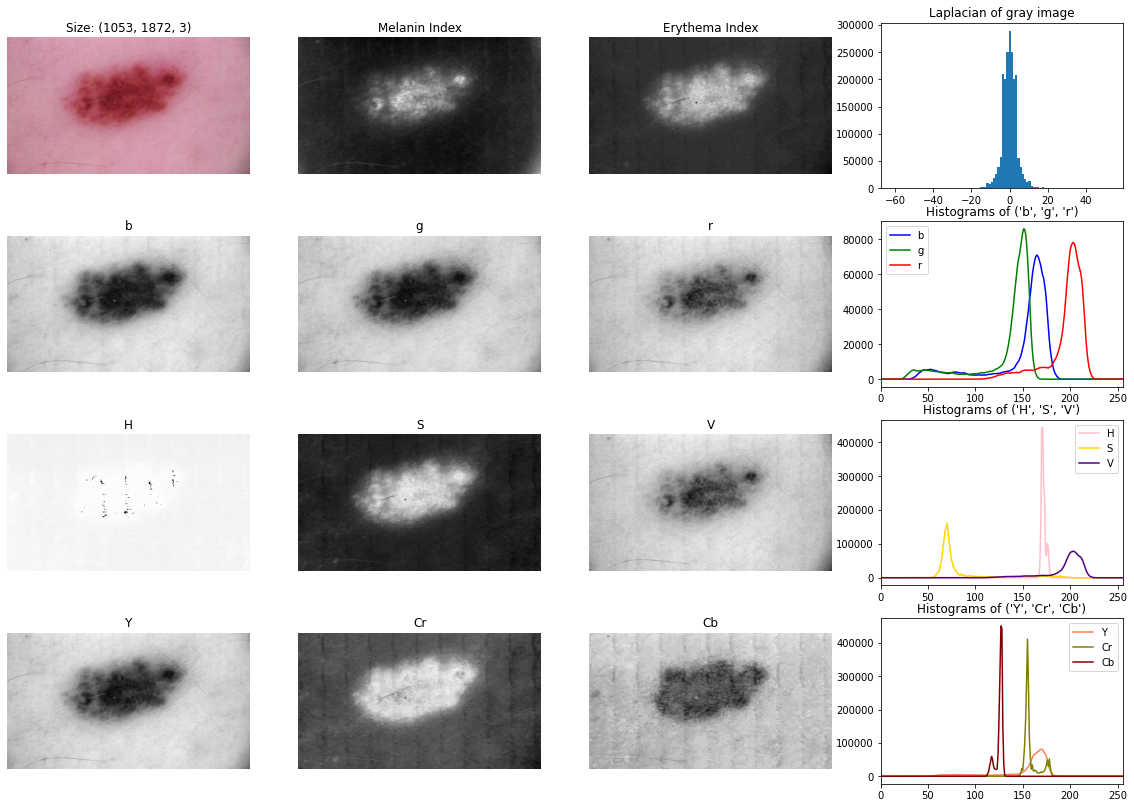

Percentiles of intensities in RGB space: {5: 63.0, 25: 145.0, 50: 160.0, 75: 193.0, 95: 211.0}
Percentiles of intensities in HSV space: {5: 66.0, 25: 80.0, 50: 171.0, 75: 194.0, 95: 211.0}
Percentiles of intensities in YCrCb space: {5: 115.0, 25: 127.0, 50: 154.0, 75: 163.0, 95: 176.0}
Sharpness Index: 
r: 15.88  g: 15.19  b: 16.00  H: 150.04  S: 8.79  V: 15.88  Y: 14.58  Cr: 0.57  Cb: 0.43  Gray: 14.58  MI: 2.05  EI: 1.36  
Full contrast: 0.58; clipped (1%-99%) contrast: 0.47
--------------------------------------------------------------------------------


In [5]:
show_image_analytics(random9_ben[:4], 'Benign')

Malignant Images


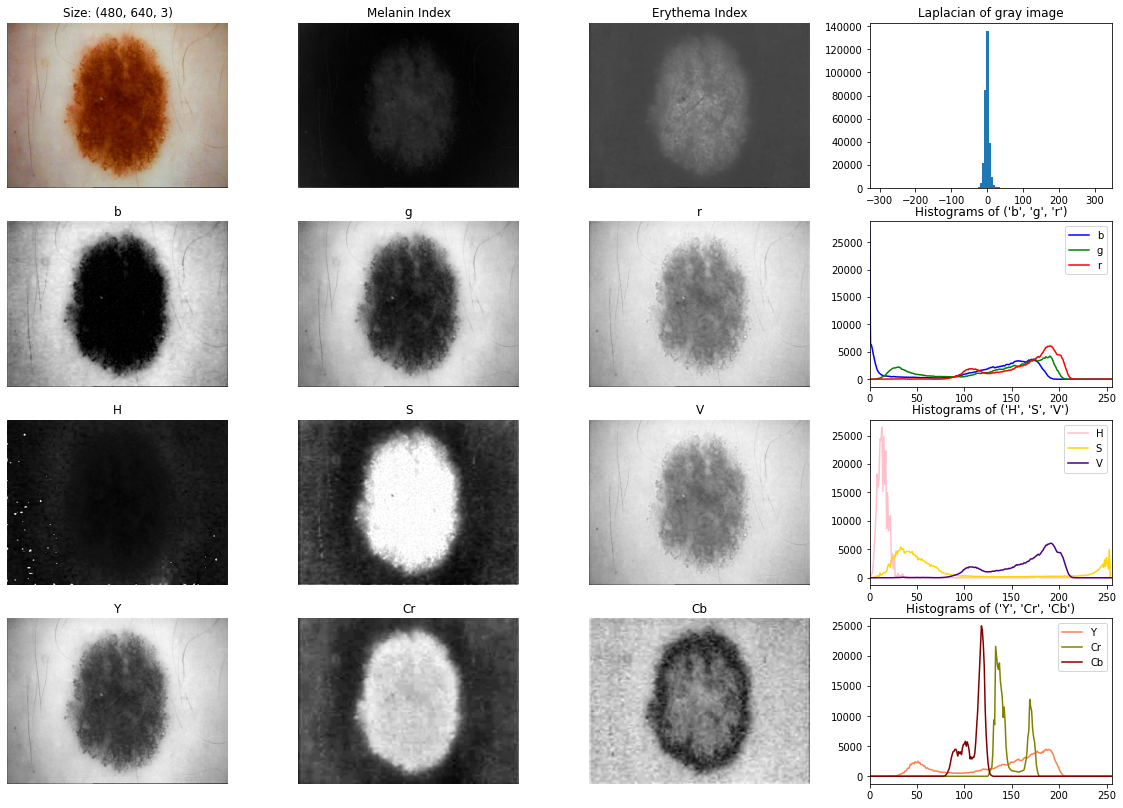

Percentiles of intensities in RGB space: {5: 4.0, 25: 110.0, 50: 154.0, 75: 179.0, 95: 198.0}
Percentiles of intensities in HSV space: {5: 8.0, 25: 17.0, 50: 56.0, 75: 177.0, 95: 247.0}
Percentiles of intensities in YCrCb space: {5: 60.0, 25: 115.0, 50: 133.0, 75: 161.0, 95: 187.0}
Sharpness Index: 
r: 201.62  g: 200.79  b: 200.89  H: 342.91  S: 165.62  V: 201.55  Y: 198.27  Cr: 1.38  Cb: 2.88  Gray: 198.27  MI: 43.19  EI: 14.00  
Full contrast: 0.84; clipped (1%-99%) contrast: 0.64
--------------------------------------------------------------------------------


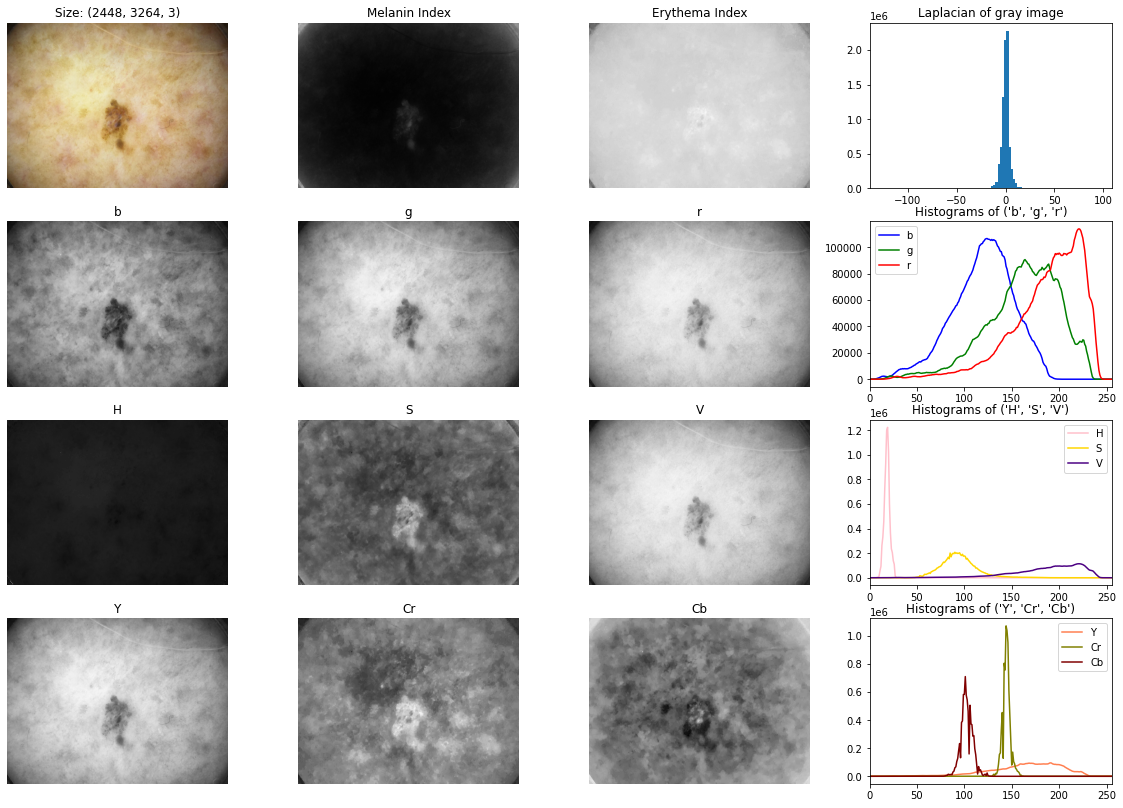

Percentiles of intensities in RGB space: {5: 77.0, 25: 124.0, 50: 158.0, 75: 193.0, 95: 225.0}
Percentiles of intensities in HSV space: {5: 15.0, 25: 20.0, 50: 92.0, 75: 169.0, 95: 223.0}
Percentiles of intensities in YCrCb space: {5: 95.0, 25: 105.0, 50: 142.0, 75: 151.0, 95: 201.0}
Sharpness Index: 
r: 16.71  g: 16.44  b: 17.44  H: 4.22  S: 16.74  V: 16.71  Y: 15.98  Cr: 0.35  Cb: 0.45  Gray: 15.98  MI: 2.91  EI: 0.89  
Full contrast: 0.93; clipped (1%-99%) contrast: 0.69
--------------------------------------------------------------------------------


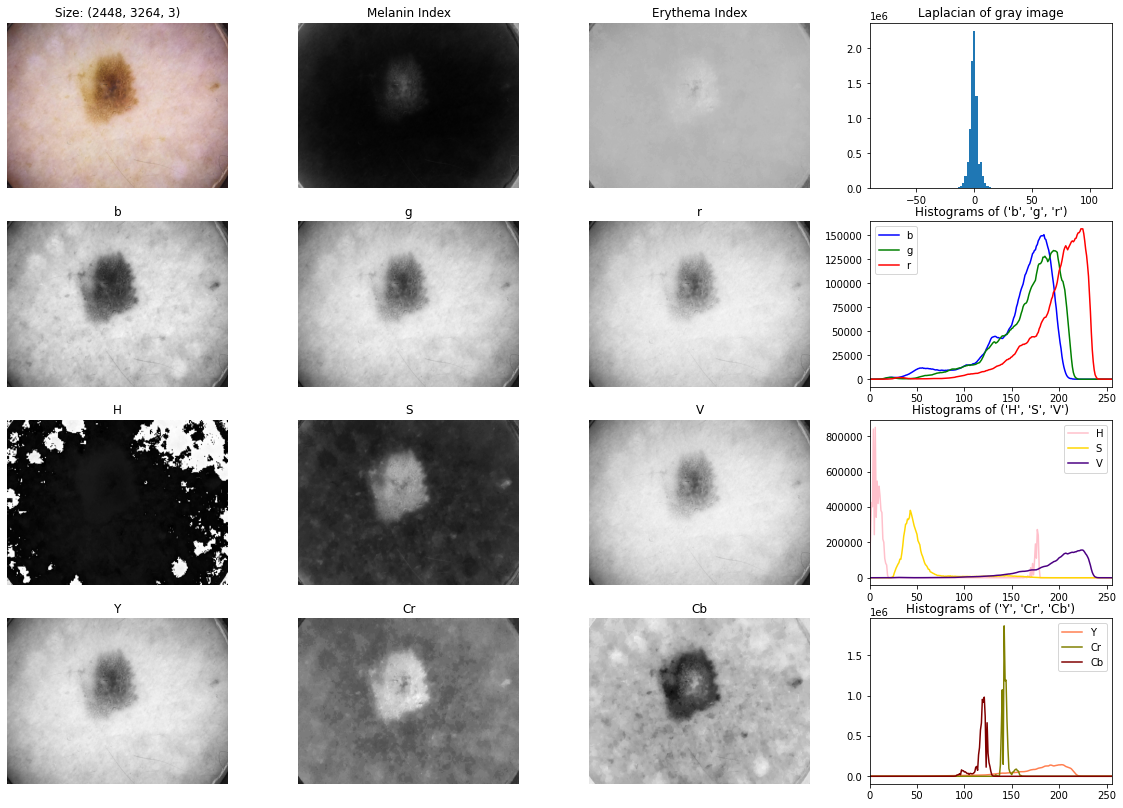

Percentiles of intensities in RGB space: {5: 102.0, 25: 158.0, 50: 181.0, 75: 200.0, 95: 225.0}
Percentiles of intensities in HSV space: {5: 4.0, 25: 13.0, 50: 49.0, 75: 184.0, 95: 225.0}
Percentiles of intensities in YCrCb space: {5: 111.0, 25: 121.0, 50: 142.0, 75: 160.0, 95: 205.0}
Sharpness Index: 
r: 15.07  g: 14.91  b: 15.72  H: 977.68  S: 8.58  V: 15.07  Y: 14.57  Cr: 0.25  Cb: 0.35  Gray: 14.57  MI: 2.31  EI: 0.68  
Full contrast: 0.89; clipped (1%-99%) contrast: 0.57
--------------------------------------------------------------------------------


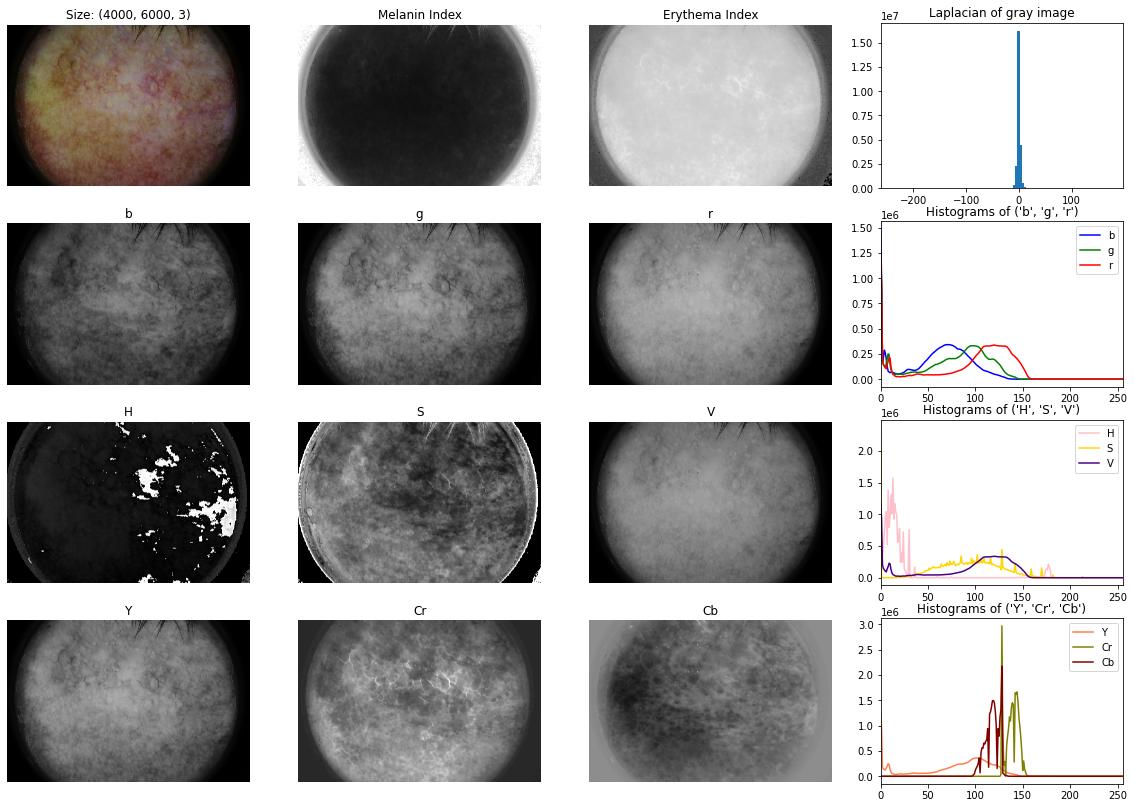

Percentiles of intensities in RGB space: {5: 0.0, 25: 46.0, 50: 82.0, 75: 109.0, 95: 136.0}
Percentiles of intensities in HSV space: {5: 0.0, 25: 12.0, 50: 71.0, 75: 115.0, 95: 146.0}
Percentiles of intensities in YCrCb space: {5: 10.0, 25: 104.0, 50: 120.0, 75: 135.0, 95: 146.0}
Sharpness Index: 
r: 7.87  g: 7.61  b: 8.15  H: 308.81  S: 118.72  V: 7.88  Y: 7.37  Cr: 0.23  Cb: 0.23  Gray: 7.37  MI: 15.67  EI: 4.72  
Full contrast: 0.86; clipped (1%-99%) contrast: 0.55
--------------------------------------------------------------------------------


In [6]:
show_image_analytics(random9_mal[:4], 'Malignant')